In [1]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph.message import add_messages
from dotenv import load_dotenv

In [2]:
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.tools import tool


1. Tool Node
2. Tool Condition

In [3]:
import requests
import random

In [4]:
load_dotenv()

True

In [5]:
llm = ChatGoogleGenerativeAI(model = 'gemini-2.5-flash')

In langchain tools are of two type prebuilt or custom.

In [6]:
# Tools
search_tool = DuckDuckGoSearchRun(region = "us-en")

@tool
def calculator(first_num: float, second_num: float, operation: str) -> dict:
    """
    Perform a basic arithmatic operation on two numbers.
    Supported operations: add, sub, mul, div
    """
    try:
        if operation == "add":
            result = first_num + second_num
        elif operation == "sub":
            result = first_num - second_num
        elif operation == "mul":
            result = first_num * second_num
        elif operation == 'div':
            if second_num == 0:
                return {"error": "Division by zero is not allowed"}
            result = first_num / second_num
        else:
            return {"error": f"Unsupported operation '{operation}' "}
        return {"first_num": first_num, "second_num": second_num, "operation": operation, "result": result}
    
    except Exception as e:
        return {"error": str(e)}
    


@tool
def get_stock_price(symbol: str) -> dict:
    """
    Fetch latest stock price for a given symbol (e.g. 'AAPL', 'TSLA')
    using Alpha Vantage with API key in the URL.
    """

    url = f"https://www.alphavantage.co/query?function=GLOBAL_QUOTE&symbol={symbol}&apikey=22TSBZ2018712L9I"
    r = requests.get(url)
    return r.json()

In [7]:
!pip show langchain-community

Name: langchain-community
Version: 0.3.30
Summary: Community contributed LangChain integrations.
Home-page: 
Author: 
Author-email: 
License: MIT
Location: D:\projects\langgraph Chatbot\myenv\Lib\site-packages
Requires: aiohttp, dataclasses-json, httpx-sse, langchain, langchain-core, langsmith, numpy, pydantic-settings, PyYAML, requests, SQLAlchemy, tenacity
Required-by: 


In [8]:
import sys
import os


print("python executable:",sys.executable)


python executable: d:\projects\langgraph Chatbot\myenv\Scripts\python.exe


In [9]:
!{sys.executable} -m pip install -U ddgs


'd:\projects\langgraph' is not recognized as an internal or external command,
operable program or batch file.


In [10]:
# make tool list

tools = [get_stock_price, search_tool, calculator]

# make the LLM tool-aware
llm_with_tools = llm.bind_tools(tools)

In [11]:
# state
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [12]:
# graph nodes
# 1st node
def chat_node(state: ChatState):
    """ LLM node that may answer or request a tool call."""
    messages = state['messages']
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}
# 2nd node
tool_node = ToolNode(tools)   # Execute tool calls

In [13]:
# graph structure

graph = StateGraph(ChatState)
graph.add_node("chat_node", chat_node)
graph.add_node("tools", tool_node)

In [14]:
graph.add_edge(START, "chat_node")

# if the LLM asked for a tool, go to ToolNode; else finish
graph.add_conditional_edges("chat_node", tools_condition)

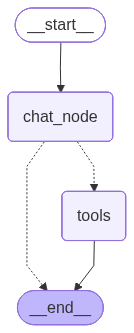

In [15]:
chatbot = graph.compile()
chatbot

In [16]:
# Regular chat

out = chatbot.invoke({"messages": [HumanMessage(content="Hello!")]})
print(out["messages"][-1].content)

Hello! How can I help you today?


In [17]:
# chat requiring tool

out = chatbot.invoke({'messages': [HumanMessage(content = "What is 2*3 ")]})
print(out['messages'][-1].content)

{"first_num": 2.0, "second_num": 3.0, "operation": "mul", "result": 6.0}


In [18]:
# chat requiring tool

out = chatbot.invoke({"messages": [HumanMessage(content = "what is the stock price of Apple?")]})
print(out['messages'][-1].content)

{"Global Quote": {"01. symbol": "AAPL", "02. open": "254.5600", "03. high": "255.0000", "04. low": "253.0100", "05. price": "254.4300", "06. volume": "40127687", "07. latest trading day": "2025-09-29", "08. previous close": "255.4600", "09. change": "-1.0300", "10. change percent": "-0.4032%"}}


In [19]:
# Chat requiring tool

out = chatbot.invoke({"messages": [HumanMessage(content = "What is the stock price of Apple, how much does it cost to buy 50 shares.")]})
print(out["messages"][-1].content)

{"Global Quote": {"01. symbol": "AAPL", "02. open": "254.5600", "03. high": "255.0000", "04. low": "253.0100", "05. price": "254.4300", "06. volume": "40127687", "07. latest trading day": "2025-09-29", "08. previous close": "255.4600", "09. change": "-1.0300", "10. change percent": "-0.4032%"}}
